# In this notebook, we will be creating a sample diversified(very) portfolio based on securities' Sharpe ratios. We will look at the monthly returns of stocks over the past year. We will then make an update to this notebook in 1 month to see how the portfolio did

## The Sharpe ratio is calculated by first subtracting a risk-free investment from the mean returns(in this case, monthly), and then dividing by the standard deviation of those returns
$$
General Formula = 
S = \frac{R_p - R_f}{\sigma_p}
$$

$$
Annualizing Monthly Sharpe Ratio = 
S_{annual} = S_{monthly} \times \sqrt{12}
$$


## This project's free return will be based on the US Treasury Bill Returns
## As of September 4, 2025, the 1-Month U.S. Treasury Bill yield—expressed as an annualized rate—is approximately 4.33%.

$$
R_{f, \text{monthly}} \approx 0.3608\%
$$


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pickle
from tqdm import tqdm
import os
import pandas_datareader.data as web
import time
from datetime import datetime
import warnings
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import sys
import networkx as nx
from selenium import webdriver
from selenium.webdriver.common.by import By
from stockdex import Ticker


import requests
from bs4 import BeautifulSoup as bs
import pprint
warnings.filterwarnings("ignore")

In [2]:
# Get Sp500 tickers
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}

response = requests.get(url, headers=headers)
tables = pd.read_html(response.text)

sp500_tickers_df = tables[0]
sp500_tickers_df["Symbol"] = sp500_tickers_df["Symbol"].str.replace(".", "-")
tickers = sp500_tickers_df.Symbol.tolist()

In [3]:
# Read in all stock data
stock_data = pd.DataFrame()

start = time.time()
print("Loading...")
# Columns returned by .yahoo_api_price: timestamp	volume	close	open	high	low	currency	timezone	exchangeTimezoneName	exchangeName	instrumentType 
for ticker in tickers:
    if ticker not in ["FOXA", "NWS", "GOOG"]: # Drop Dupliactes
        temp_tick = Ticker(ticker)
        security_df = temp_tick.yahoo_api_price(range='1y', dataGranularity='1d')
        security_df = security_df[["timestamp", "low", "high", "open", "close", "instrumentType"]]
        security_df["Symbol"] = ticker
    
        stock_data = pd.concat([stock_data, security_df])
end = time.time()

print(f"Finished: {end - start}")

Loading...
Finished: 101.39542508125305


In [4]:
# Copy df to not have to rerun above loop
sp500_prices_df = stock_data.copy()
#

In [5]:
# Scrape large index funds using selium and eventually add to the df
url_categories = ["index-etfs", "sector-etfs", "commodity-etfs", "country-etfs"]
etfs = pd.DataFrame()

for url in url_categories:
    data = []
    driver = webdriver.Chrome()  
    driver.get(f"https://www.cnbc.com/{url}/")
    time.sleep(5)  
    
    # Locate the table
    table = driver.find_element(By.CLASS_NAME, "BasicTable-tableBody") # Class of table
    
    # Extract rows
    rows = table.find_elements(By.TAG_NAME, "tr")
    

    for row in rows:
        cols = [col.text for col in row.find_elements(By.TAG_NAME, "td")]
        if cols:
            data.append(cols)
    
    df = pd.DataFrame(data)
    df = df[df.columns[:2]]
    df.columns = ["Ticker", "Name"]
    df["Type"] = url
    display(df.head())
    print()


    etfs = pd.concat([etfs, df])
    
    
    driver.quit()

,Ticker,Name,Type
0,SPY,SPDR S&P 500 ETF Trust,index-etfs
1,QQQ,Invesco QQQ Trust,index-etfs
2,IWM,iShares Russell 2000 ETF,index-etfs
3,DIA,SPDR Dow Jones Industrial Average ETF Trust,index-etfs
4,VTI,Vanguard Total Stock Market Index Fund ETF Shares,index-etfs


,Ticker,Name,Type
0,XLE,Energy Select Sector SPDR Fund,sector-etfs
1,XLF,Financial Select SPDR Fund,sector-etfs
2,XLU,Utilities Select Sector SPDR Fund,sector-etfs
3,XLI,Industrial Select Sector SPDR Fund,sector-etfs
4,GDX,VanEck Gold Miners ETF,sector-etfs


,Ticker,Name,Type
0,GLD,SPDR Gold Shares,commodity-etfs
1,SLV,iShares Silver Trust,commodity-etfs
2,UNG,United States Natural Gas Fund,commodity-etfs
3,USO,"United States Oil Fund, LP",commodity-etfs
4,IAU,iShares Gold Trust,commodity-etfs


,Ticker,Name,Type
0,EWJ,iShares MSCI Japan ETF,country-etfs
1,FXI,iShares China Large-Cap ETF,country-etfs
2,EWZ,iShares MSCI Brazil ETF,country-etfs
3,EWT,iShares MSCI Taiwan ETF,country-etfs
4,DXJ,WisdomTree Japan Hedged Equity Fund,country-etfs


In [6]:
# Save important info
etfs_symbols = etfs.Ticker.tolist()
etf_type_dict = dict(zip(etfs["Ticker"], etfs["Type"]))
etfs.head()

,Ticker,Name,Type
0,SPY,SPDR S&P 500 ETF Trust,index-etfs
1,QQQ,Invesco QQQ Trust,index-etfs
2,IWM,iShares Russell 2000 ETF,index-etfs
3,DIA,SPDR Dow Jones Industrial Average ETF Trust,index-etfs
4,VTI,Vanguard Total Stock Market Index Fund ETF Shares,index-etfs


In [7]:
# Get all etf data
etf_temp = pd.DataFrame()

# Same thing from above
start = time.time()
print("Loading...")
for e in etfs_symbols:
    temp_tick = Ticker(e)
    temp_df = temp_tick.yahoo_api_price(range='1y', dataGranularity='1d')
    temp_df = temp_df[["timestamp", "low", "high", "open", "close", "instrumentType"]]
    temp_df["Symbol"] = e

    etf_temp = pd.concat([etf_temp, temp_df])
end = time.time()

print(f"Finished: {end-start}")

Loading...
Finished: 15.426220655441284


In [8]:
#copy over
etf_prices = etf_temp.copy()
etf_prices = etf_prices.query('Symbol not in ["SIVR", "GDX", "SGOL"]')

In [9]:
print("------------------------------------------- SP500 DATA -------------------------------------------")
display(sp500_prices_df.head(10))
print(); print()

print("-------------------------------------------- ETF Data --------------------------------------------")
display(etf_prices.head(10))

------------------------------------------- SP500 DATA -------------------------------------------


,timestamp,low,high,open,close,instrumentType,Symbol
0,2024-09-05 13:30:00,130.699997,132.949997,131.919998,131.399994,EQUITY,MMM
1,2024-09-06 13:30:00,128.020004,132.100006,130.500000,128.600006,EQUITY,MMM
2,2024-09-09 13:30:00,128.190002,130.979996,129.389999,128.460007,EQUITY,MMM
3,2024-09-10 13:30:00,128.460007,130.160004,128.850006,130.089996,EQUITY,MMM
4,2024-09-11 13:30:00,127.120003,130.380005,129.500000,130.229996,EQUITY,MMM
5,2024-09-12 13:30:00,130.100006,132.720001,130.300003,132.029999,EQUITY,MMM
6,2024-09-13 13:30:00,131.350006,133.369995,131.880005,133.179993,EQUITY,MMM
7,2024-09-16 13:30:00,133.830002,135.279999,133.979996,134.610001,EQUITY,MMM
8,2024-09-17 13:30:00,132.309998,134.429993,134.089996,133.570007,EQUITY,MMM
9,2024-09-18 13:30:00,131.759995,134.279999,133.259995,133.360001,EQUITY,MMM




-------------------------------------------- ETF Data --------------------------------------------


,timestamp,low,high,open,close,instrumentType,Symbol
0,2024-09-05 13:30:00,547.099976,553.799988,550.890015,549.609985,ETF,SPY
1,2024-09-06 13:30:00,539.440002,551.599976,549.940002,540.359985,ETF,SPY
2,2024-09-09 13:30:00,542.679993,547.710022,544.650024,546.409973,ETF,SPY
3,2024-09-10 13:30:00,543.380005,549.150024,548.359985,548.789978,ETF,SPY
4,2024-09-11 13:30:00,539.960022,555.359985,548.700012,554.419983,ETF,SPY
5,2024-09-12 13:30:00,552.739990,559.400024,555.010010,559.090027,ETF,SPY
6,2024-09-13 13:30:00,559.450012,563.030029,559.710022,562.010010,ETF,SPY
7,2024-09-16 13:30:00,559.900024,563.109985,561.739990,562.840027,ETF,SPY
8,2024-09-17 13:30:00,560.789978,566.580017,565.099976,563.070007,ETF,SPY
9,2024-09-18 13:30:00,560.830017,568.690002,563.739990,561.400024,ETF,SPY


In [10]:
# Concatonate both dfs
all_security_data = pd.concat([sp500_prices_df, etf_prices])
all_security_data = all_security_data.set_index("timestamp")

In [11]:
# Get monthly_pct_change
all_security_data['(t+1)'] = all_security_data.groupby('Symbol')['close'].shift(-21) 
all_security_data["Monthly_Pct_Change"] = (all_security_data['(t+1)'] - all_security_data['close']) / all_security_data['close']
all_security_data = all_security_data.drop(columns = "(t+1)")

all_security_data

,low,high,open,close,instrumentType,Symbol,Monthly_Pct_Change
timestamp,,,,,,,
2024-09-05 13:30:00,130.699997,132.949997,131.919998,131.399994,EQUITY,MMM,0.029452
2024-09-06 13:30:00,128.020004,132.100006,130.500000,128.600006,EQUITY,MMM,0.048600
2024-09-09 13:30:00,128.190002,130.979996,129.389999,128.460007,EQUITY,MMM,0.048498
2024-09-10 13:30:00,128.460007,130.160004,128.850006,130.089996,EQUITY,MMM,0.037820
2024-09-11 13:30:00,127.120003,130.380005,129.500000,130.229996,EQUITY,MMM,0.024802
...,...,...,...,...,...,...,...
2025-08-28 13:30:00,57.020000,57.340000,57.250000,57.150002,ETF,EZA,NaN
2025-08-29 13:30:00,56.930000,57.700001,56.930000,57.669998,ETF,EZA,NaN
2025-09-02 13:30:00,56.549999,57.320000,56.680000,57.250000,ETF,EZA,NaN


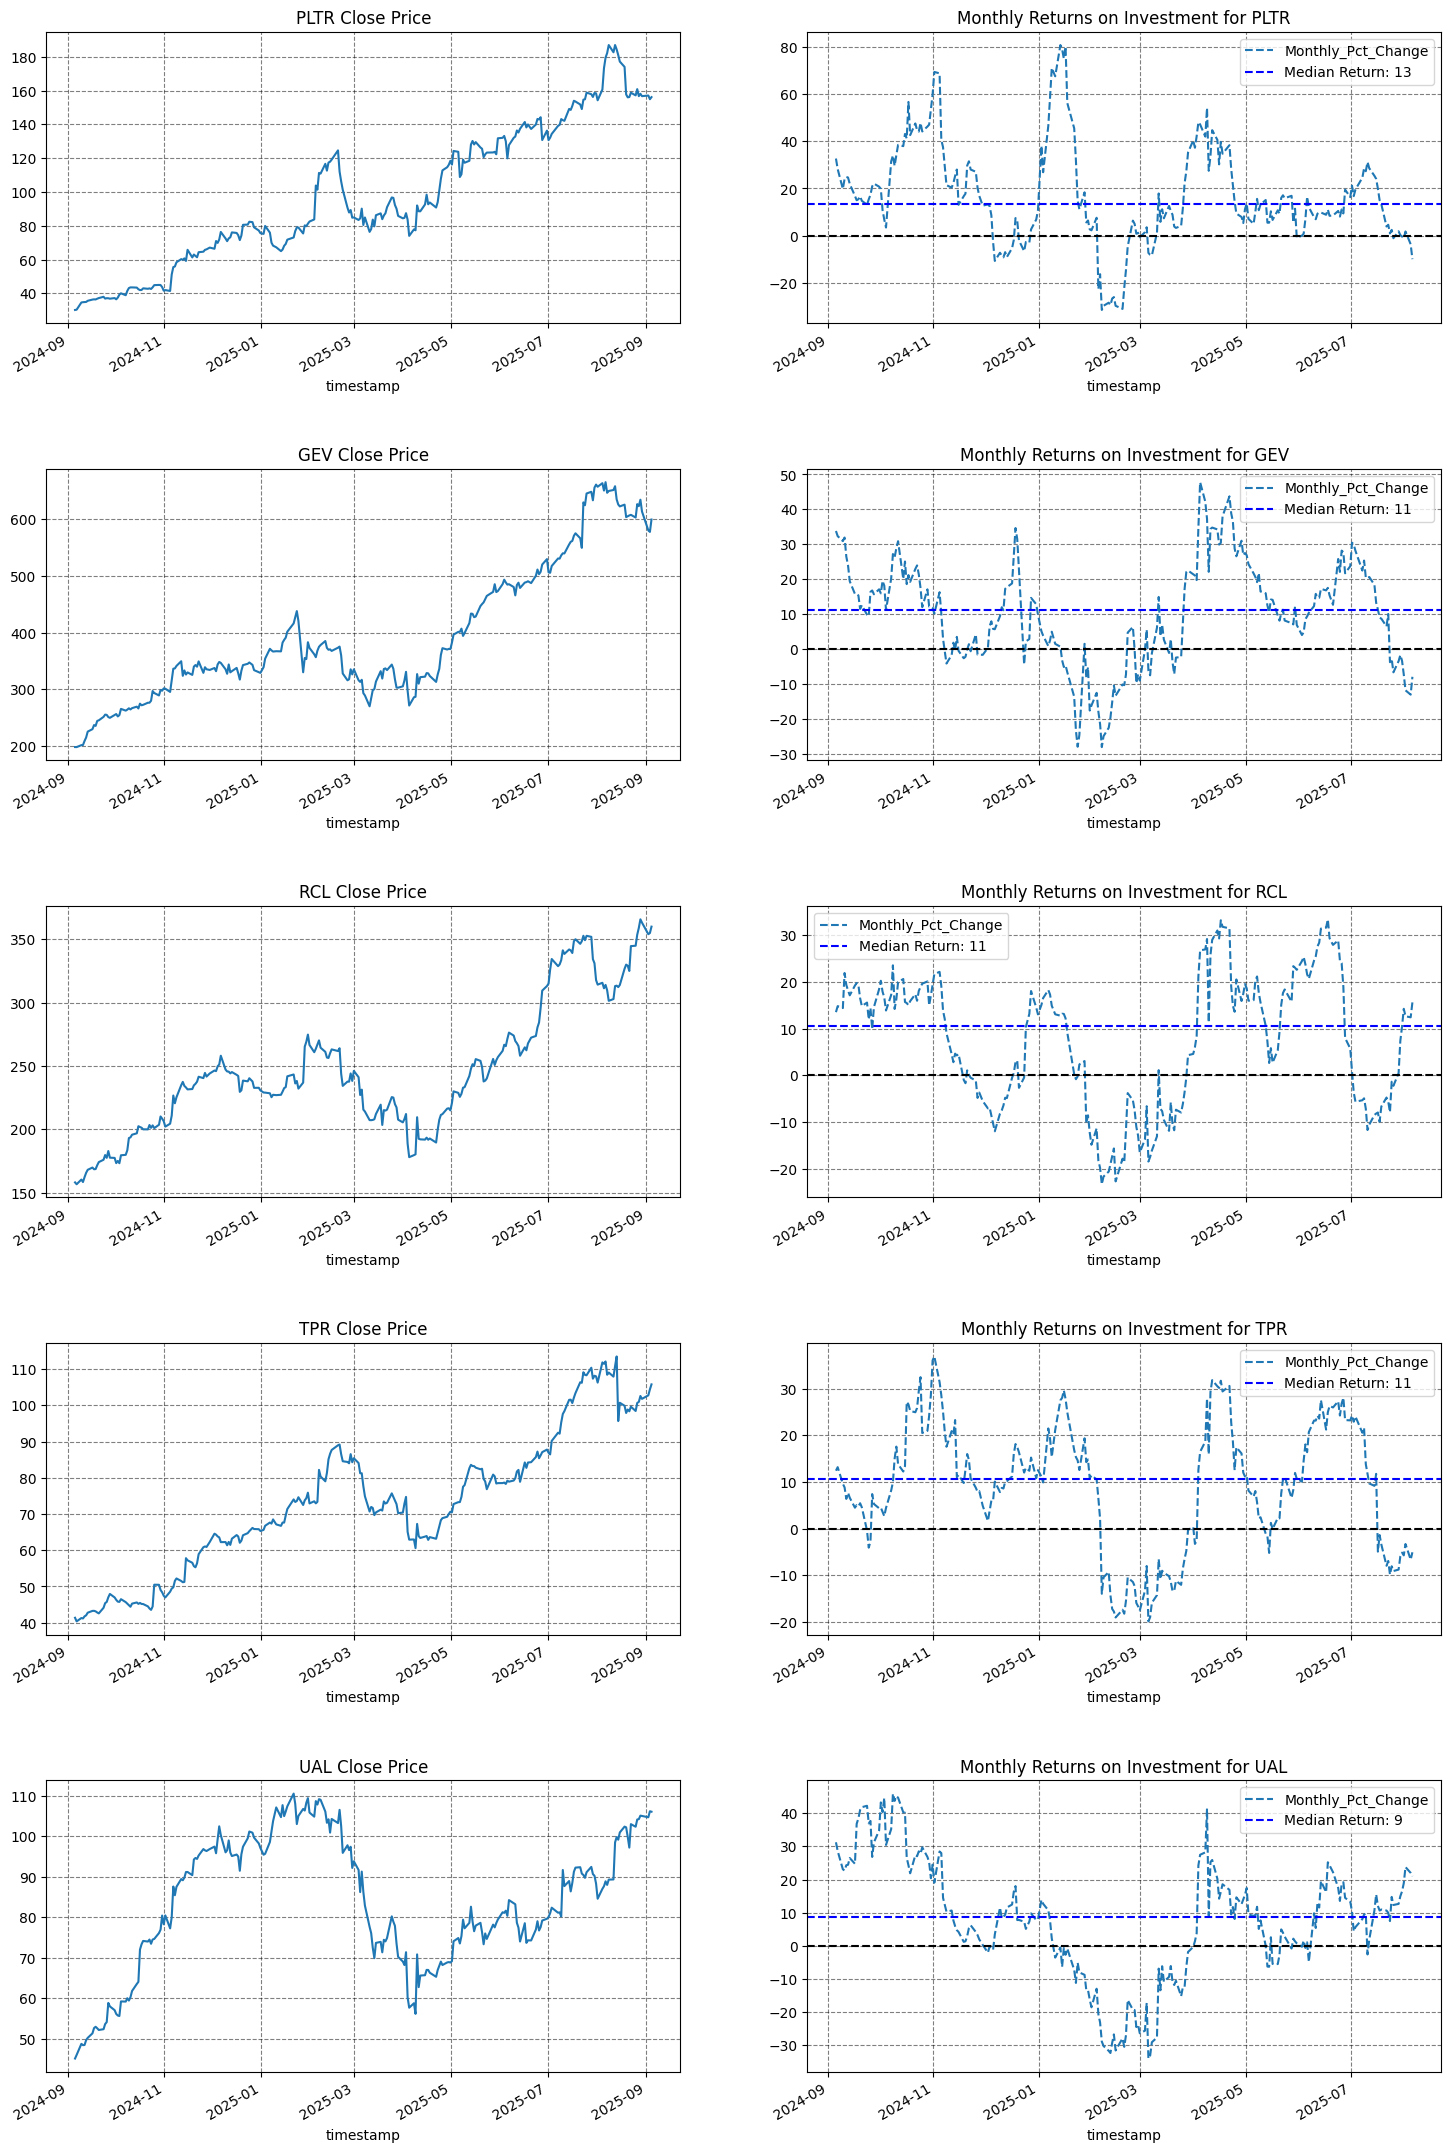

In [12]:
# Plot well performing stocks
top_performers = all_security_data.groupby('Symbol', as_index = False)["Monthly_Pct_Change"].median()
top_performers = top_performers.sort_values(by = "Monthly_Pct_Change", ascending = False).head(5)

# Plot best performing stocks(based off of 1 month return) over the past 6 months
fig, ax = plt.subplots(5, 2, figsize = (18, 30))
#fig.suptitle("Best Performing Stocks Based on 1-Month Returns")
for i, symb in enumerate(top_performers.Symbol):
    
    temp = all_security_data.query('Symbol == @symb')
    temp["Monthly_Pct_Change"] = temp["Monthly_Pct_Change"] * 100
    temp.close.plot(ax = ax[i, 0]); ax[i, 0].set_title(f"{symb} Close Price")
    temp.Monthly_Pct_Change.plot(ax=ax[i, 1], linestyle = '--'); ax[i, 1].axhline(y = 0, color = 'k', linestyle = '--') 

    lab = f"Median Return: {round(float(top_performers.query('Symbol == @symb')['Monthly_Pct_Change']) * 100)}"
    ax[i, 1].axhline(y=float(top_performers.query('Symbol == @symb')['Monthly_Pct_Change'])*100, color='blue', linestyle='--', label=lab)
    ax[i, 1].legend()

    
    ax[i, 1].set_title(f"Monthly Returns on Investment for {symb}")
    
    ax[i,0].grid(linestyle = '--', alpha = 0.5, color = 'k'); ax[i,1].grid(linestyle = '--', alpha = 0.5, color = 'k')

plt.subplots_adjust(hspace = 0.5)

## Here, we will group stocks into buckets/graphs to diversify our portfolio. Each group theorectically will represent a sector or branch of the economy. We will do this grouping by seeing which stocks have the most similar monthly returns in terms of correlation

### We will use the networx library to make easy groupings based off of correlations of stock returns from month-to-month

In [13]:
# Widen df to calculate correlations between monthly returns of stocks
stock_data_wide = all_security_data.dropna().pivot_table(
    index="timestamp",
    columns="Symbol",
    values="Monthly_Pct_Change"
)
stock_corr = stock_data_wide.corr().rename_axis(index="Ticker2", columns="Ticker1")

display(stock_corr)

Ticker1,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ACWI,ADBE,ADI,...,XOM,XOP,XRT,XTL,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
Ticker2,,,,,,,,,,,,,,,,,,,,,
A,1.000000,0.366204,0.123479,0.378437,0.218889,0.205445,0.561148,0.696495,0.367238,0.546682,...,0.260227,0.687846,0.697905,0.687369,0.517166,0.501743,-0.133518,0.142715,0.722842,0.572564
AAPL,0.366204,1.000000,0.350221,0.436693,0.072115,-0.124198,0.293700,0.519137,0.303682,0.499601,...,-0.048473,0.130789,0.529407,0.628778,0.446920,0.342021,0.299362,0.115692,0.327407,0.153692
ABBV,0.123479,0.350221,1.000000,0.238188,0.403749,0.156359,0.027432,0.247118,0.156738,0.466294,...,0.236384,0.057718,-0.107517,0.232240,0.469919,-0.390521,0.610939,0.255594,-0.107852,0.349945
ABNB,0.378437,0.436693,0.238188,1.000000,0.360510,-0.163596,0.721181,0.723311,0.607477,0.680415,...,0.197582,0.429095,0.526626,0.581989,0.546607,0.315493,0.334260,-0.347606,0.499404,0.293602
ABT,0.218889,0.072115,0.403749,0.360510,1.000000,0.129066,0.500875,0.324681,0.494462,0.288582,...,0.125339,0.130987,0.072506,0.134068,0.486630,-0.176427,0.452622,-0.096765,-0.138509,0.414411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYZ,0.501743,0.342021,-0.390521,0.315493,-0.176427,-0.208390,0.345634,0.491813,0.346736,0.095306,...,0.003758,0.443296,0.755349,0.594308,0.180574,1.000000,-0.282408,0.080117,0.661751,0.099689
YUM,-0.133518,0.299362,0.610939,0.334260,0.452622,0.027036,0.121819,0.213361,0.371965,0.276560,...,0.272813,-0.012321,-0.118029,0.178590,0.362095,-0.282408,1.000000,0.114629,-0.220818,0.183012
ZBH,0.142715,0.115692,0.255594,-0.347606,-0.096765,0.226789,-0.324806,-0.065142,-0.076752,-0.080514,...,0.342845,0.225463,-0.002451,0.145539,-0.081415,0.080117,0.114629,1.000000,0.042459,0.086474


In [14]:
# Unstack to show direct comparisons
stock_corr = stock_corr.unstack().sort_values(ascending = False)
stock_corr = stock_corr[stock_corr < 0.999999]

In [15]:
stock_corr_compare = stock_corr.copy()
stock_corr_compare = stock_corr_compare.reset_index()

stock_corr_compare.columns = ["Ticker1", "Ticker2", "Monthly_Pct_Change_Corr"]
stock_corr_compare["Pairs"] = stock_corr_compare.apply(
    lambda row: tuple(sorted([row["Ticker1"], row["Ticker2"]])), axis=1
)

stock_corr_compare = stock_corr_compare.drop_duplicates(subset = ["Pairs"])
stock_corr_compare = stock_corr_compare.drop(columns = "Pairs")

In [16]:
stock_corr_compare.head(25)

,Ticker1,Ticker2,Monthly_Pct_Change_Corr
0,IAU,GLD,0.999962
2,IJH,MDY,0.999814
4,VOO,SPY,0.999472
6,VTI,VOO,0.998107
8,SPY,VTI,0.997866
10,XLE,IYE,0.996905
12,KBE,KRE,0.996784
14,BNO,USO,0.994605
16,IWF,QQQ,0.994125
18,VNQ,IYR,0.991269


In [17]:
# -- Create Groups --
# Threshold for correlation
threshold = 0.8825 # 88.25% correlation

# Filter edges
df_filtered = stock_corr_compare[stock_corr_compare["Monthly_Pct_Change_Corr"] >= threshold]

# Build graph
G = nx.Graph()
for _, row in df_filtered.iterrows():
    G.add_edge(row["Ticker1"], row["Ticker2"], weight=row["Monthly_Pct_Change_Corr"])

# Connected components (looser groups)
clusters = list(nx.connected_components(G))
clusters = [list(c) for c in clusters]

print("Connected Component Clusters:")
for i, cluster in enumerate(clusters, 1):
    print(f"Cluster {i}: {cluster}")

Connected Component Clusters:
Cluster 1: ['IAU', 'GLD']
Cluster 2: ['IWF', 'C', 'RCL', 'IJH', 'KRE', 'OEF', 'XLF', 'JPM', 'IR', 'STT', 'BAC', 'MDY', 'EWT', 'CCL', 'MTB', 'NTRS', 'RF', 'GS', 'IWM', 'HBAN', 'DAL', 'IWN', 'NCLH', 'BX', 'KEY', 'NVDA', 'SMH', 'NDSN', 'XLY', 'XLB', 'FITB', 'ACWI', 'KKR', 'EMR', 'HLT', 'USB', 'CFG', 'CPAY', 'SPY', 'DOV', 'PH', 'VTI', 'PNR', 'XLI', 'AMP', 'UAL', 'AMZN', 'SYF', 'JBHT', 'DIA', 'IWD', 'TRMB', 'ZBRA', 'MS', 'QQQ', 'SYK', 'XLK', 'WFC', 'LRCX', 'VOO', 'WDC', 'XTL', 'AXP', 'NTAP', 'TFC', 'IWO', 'STX', 'TROW', 'COF', 'XRT', 'MAR', 'PNC', 'KBE', 'KLAC', 'KEYS', 'RJF']
Cluster 3: ['XLE', 'SLB', 'VLO', 'HAL', 'CVX', 'MPC', 'OIH', 'PSX', 'IYE', 'EOG', 'XOP']
Cluster 4: ['DBE', 'USO', 'DBO', 'GSG', 'BNO', 'UGA', 'DBC']
Cluster 5: ['IYR', 'VNQ']
Cluster 6: ['ITB', 'DHI', 'LEN', 'PHM', 'XHB', 'NVR', 'MHK']
Cluster 7: ['EWP', 'EWG', 'EWU', 'EWL', 'EWI', 'FEZ']
Cluster 8: ['EWA', 'EWC']
Cluster 9: ['XYL', 'MCO', 'SPGI']
Cluster 10: ['CPT', 'EQR', 'UDR', 'ESS']

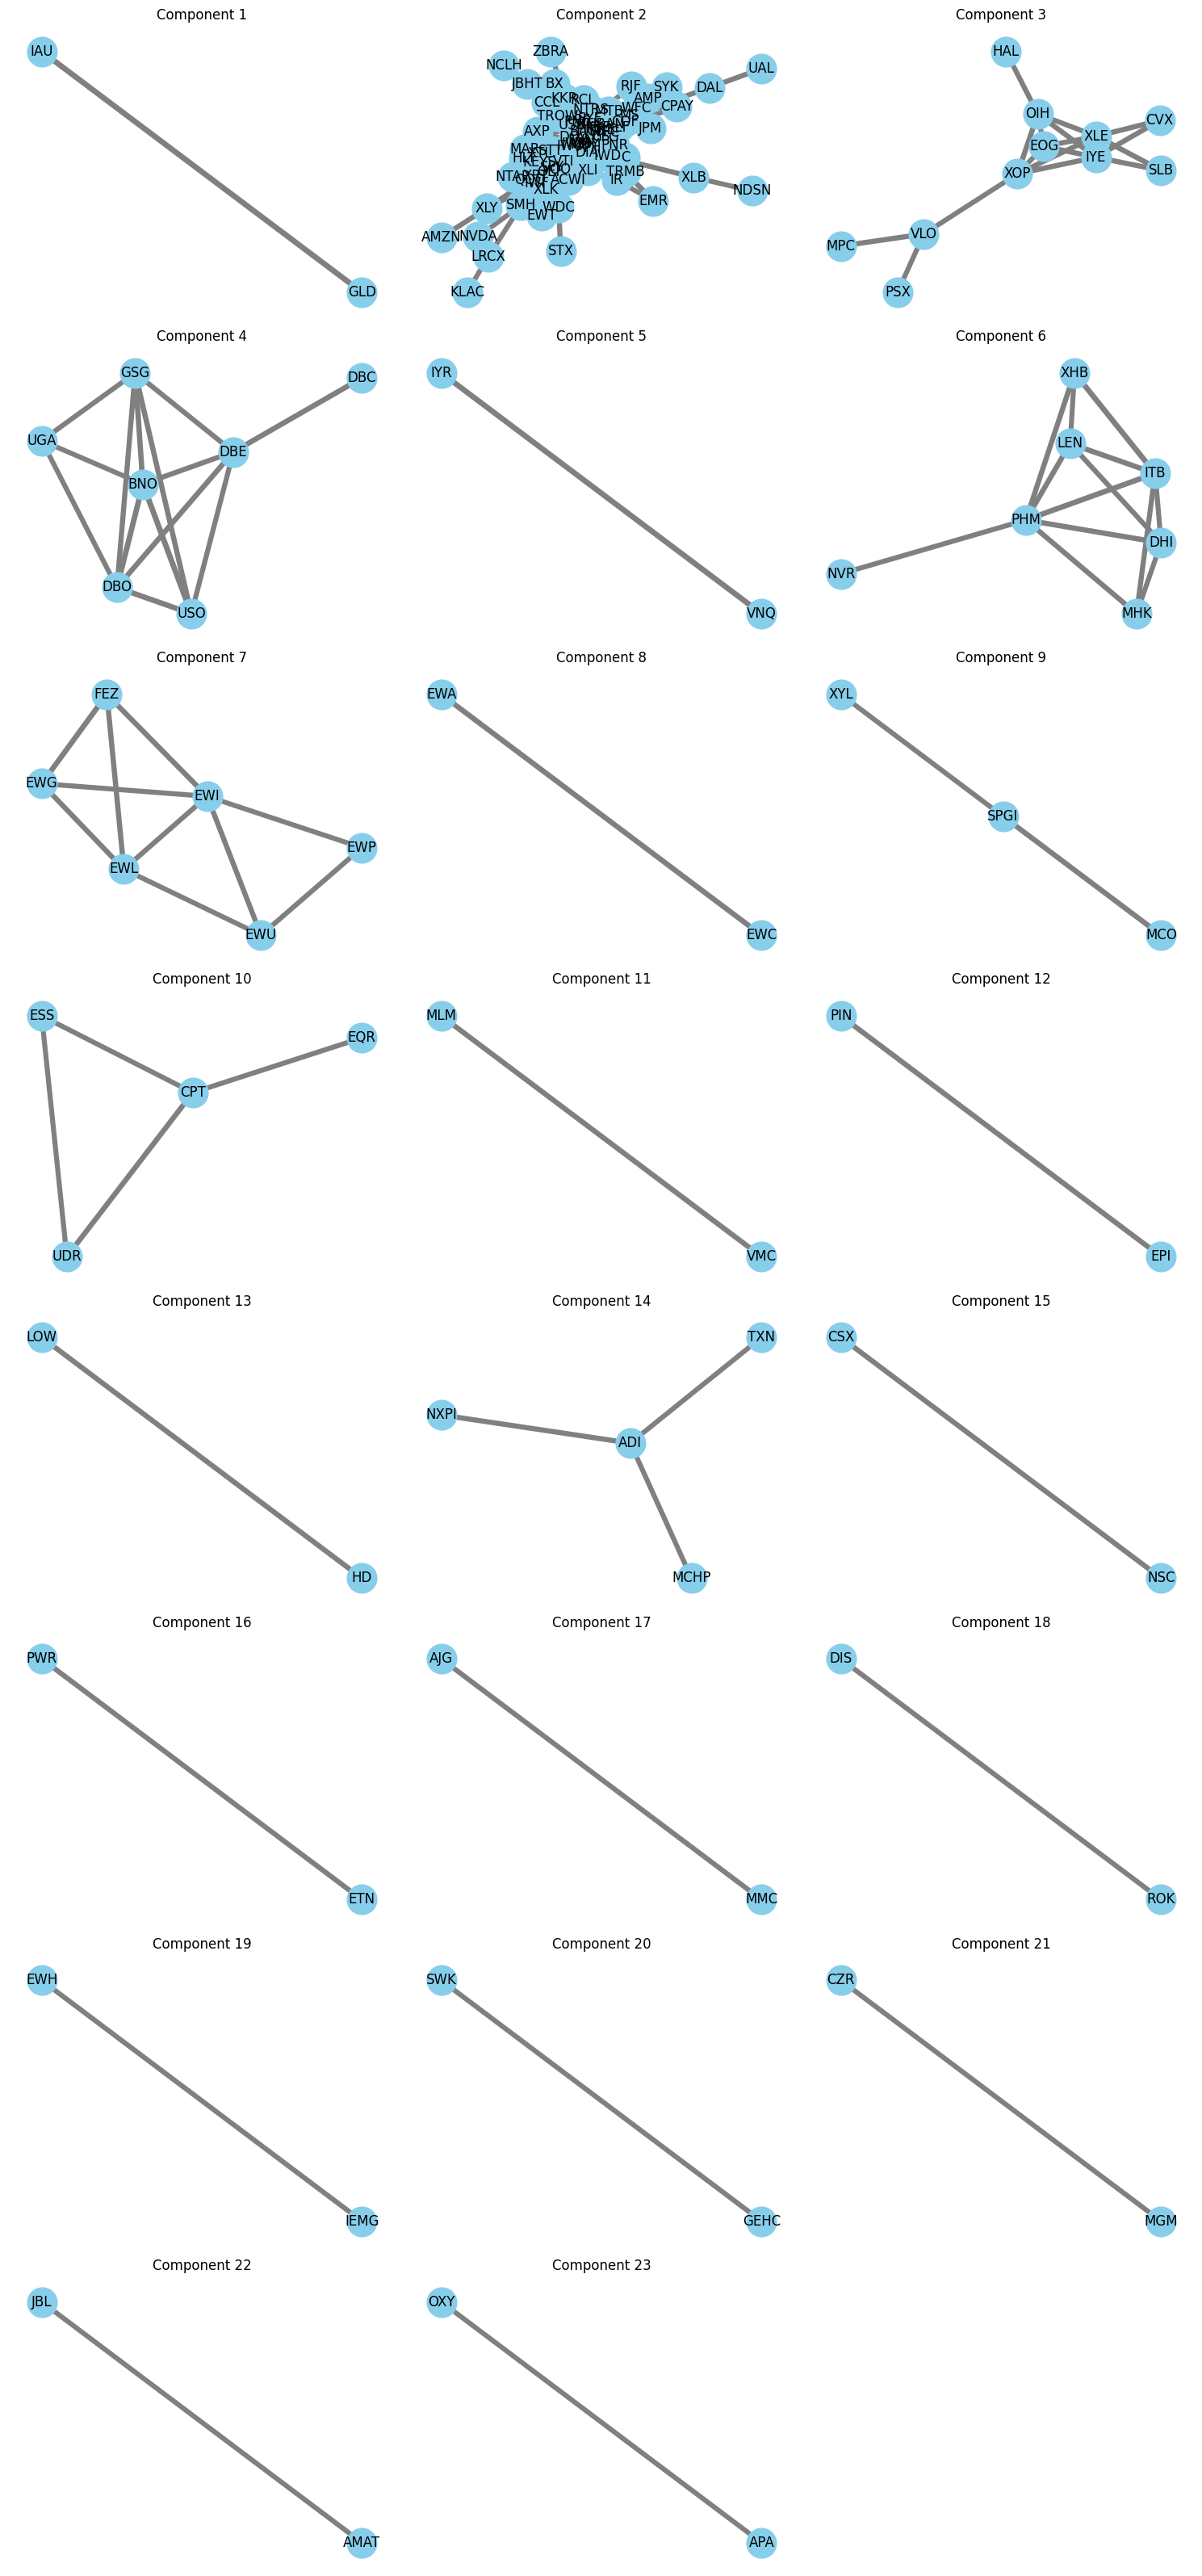

In [18]:
components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
n = len(components)
cols = 3  # number of columns in grid
rows = -(-n // cols)  # ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))

# If only one subplot (e.g., 1 component), wrap axes in list
if n == 1:
    axes = [[axes]]
elif rows == 1:
    axes = [axes]  # make it 2D for consistency

axes = [ax for row_axes in axes for ax in (row_axes if isinstance(row_axes, (list, np.ndarray)) else [row_axes])]

for i, component in enumerate(components):
    ax = axes[i]
    pos = nx.spring_layout(component, seed=42)
    
    # Draw nodes, edges, and labels
    nx.draw(component, pos, ax=ax, with_labels=True, node_color='skyblue', node_size=700,
            edge_color='gray', width=[component[u][v]['weight'] * 5 for u, v in component.edges()])
    
    ax.set_title(f"Component {i+1}")
    ax.axis('off')

# Turn off unused axes
for j in range(len(components), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [19]:
# RISK FREE RETURN BASED OF OFF US TREASSURY NOTE
# ANNUALIZED RETURN FOR NOTE IS 4.33%
RISK_FREE_RETURN =  (4.33/100)/12 # Divide for 12 months in a year

def calc_sharpe_ratio(stocks, all_security_data):
    """
    Create a function to calculate the Sharpe ratios of a list of stocks. 
    Save top security and more if thresholds are met.

    Input: list of stocks
    Output: df
    """
    sharpe_ratios = []
    
    for stock in stocks:
        temp = all_security_data.query('Symbol == @stock')
        
        pct_change_avg = temp.Monthly_Pct_Change.mean()
        dev_returns = temp.Monthly_Pct_Change.std()
        
        if dev_returns == 0:
            print(f"Standard deviation is zero for {stock}, skipping...")
            continue

        monthly_sharpe_ratio = (pct_change_avg - RISK_FREE_RETURN) / dev_returns
        
        print(f"Sharpe Ratio (Monthly) for {stock}: {monthly_sharpe_ratio:.4f}")
        print(f"Sharpe Ratio (Annualized): {monthly_sharpe_ratio * np.sqrt(12):.4f}")
        print("-----------------------------------------------------------------------------------------")

        if monthly_sharpe_ratio >= 0.25:
            sharpe_ratios.append(
                (stock, monthly_sharpe_ratio, monthly_sharpe_ratio * np.sqrt(12))
            )
        print()
    
    if not sharpe_ratios:
        print("No good stocks")
        return

    sharpe_df = pd.DataFrame(sharpe_ratios, columns=["Symbol", "Monthly_Sharpe_Ratio", "Annualized_Sharpe_Ratio"])
    sharpe_df = sharpe_df.sort_values(by="Annualized_Sharpe_Ratio", ascending=False)

    top_sharpe_df = sharpe_df.head(1)
    filtered_remainder = sharpe_df[1:].query('Annualized_Sharpe_Ratio >= .9')

    if filtered_remainder.empty:
        return top_sharpe_df

    return pd.concat([top_sharpe_df, filtered_remainder])

# Initialize Portfolio df here with previously seen best performing stocks
portfolio_df = calc_sharpe_ratio(top_performers.Symbol, all_security_data)

Sharpe Ratio (Monthly) for PLTR: 0.7910
Sharpe Ratio (Annualized): 2.7402
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for GEV: 0.6789
Sharpe Ratio (Annualized): 2.3517
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for RCL: 0.4922
Sharpe Ratio (Annualized): 1.7049
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for TPR: 0.6384
Sharpe Ratio (Annualized): 2.2115
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for UAL: 0.4041
Sharpe Ratio (Annualized): 1.3998
-----------------------------------------------------------------------------------------



In [20]:
# Create Portfolio
for i, cluster in enumerate(clusters, 1):
    print(f"Cluster {i}")
    temp = calc_sharpe_ratio(cluster, all_security_data)
    display(temp)

    portfolio_df = pd.concat([portfolio_df, temp])
    
    print()

Cluster 1
Sharpe Ratio (Monthly) for IAU: 0.5648
Sharpe Ratio (Annualized): 1.9564
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for GLD: 0.5613
Sharpe Ratio (Annualized): 1.9444
-----------------------------------------------------------------------------------------



,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio
0,IAU,0.564764,1.956401
1,GLD,0.561310,1.944434



Cluster 2
Sharpe Ratio (Monthly) for IWF: 0.2690
Sharpe Ratio (Annualized): 0.9318
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for C: 0.4510
Sharpe Ratio (Annualized): 1.5622
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for RCL: 0.4922
Sharpe Ratio (Annualized): 1.7049
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for IJH: 0.0408
Sharpe Ratio (Annualized): 0.1413
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for KRE: 0.1274
Sharpe Ratio (Annualized): 0.4413
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for OEF: 0.2554
Sharpe Ratio (Annualized): 0.8847
-----------------------------------------------------------------------------------------

Sharpe 

,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio
2,RCL,0.492175,1.704943
1,C,0.450971,1.562210
5,JPM,0.422155,1.462387
20,COF,0.404422,1.400960
11,UAL,0.404096,1.399830
9,GS,0.403434,1.397538
7,CCL,0.396804,1.374568
14,MS,0.371418,1.286628
16,WFC,0.365755,1.267013
18,XTL,0.358524,1.241962



Cluster 3
Sharpe Ratio (Monthly) for XLE: -0.0415
Sharpe Ratio (Annualized): -0.1439
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for SLB: -0.2221
Sharpe Ratio (Annualized): -0.7695
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for VLO: 0.0564
Sharpe Ratio (Annualized): 0.1955
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for HAL: -0.3241
Sharpe Ratio (Annualized): -1.1227
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for CVX: 0.0950
Sharpe Ratio (Annualized): 0.3291
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for MPC: 0.0356
Sharpe Ratio (Annualized): 0.1234
-----------------------------------------------------------------------------------------


None


Cluster 4
Sharpe Ratio (Monthly) for DBE: -0.0275
Sharpe Ratio (Annualized): -0.0952
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for USO: 0.0406
Sharpe Ratio (Annualized): 0.1406
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for DBO: -0.1014
Sharpe Ratio (Annualized): -0.3514
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for GSG: 0.1081
Sharpe Ratio (Annualized): 0.3743
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for BNO: 0.0435
Sharpe Ratio (Annualized): 0.1508
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for UGA: 0.0811
Sharpe Ratio (Annualized): 0.2810
-----------------------------------------------------------------------------------------

S

None


Cluster 5
Sharpe Ratio (Monthly) for IYR: -0.2247
Sharpe Ratio (Annualized): -0.7783
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for VNQ: -0.2550
Sharpe Ratio (Annualized): -0.8834
-----------------------------------------------------------------------------------------

No good stocks


None


Cluster 6
Sharpe Ratio (Monthly) for ITB: -0.1716
Sharpe Ratio (Annualized): -0.5944
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for DHI: -0.1252
Sharpe Ratio (Annualized): -0.4336
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for LEN: -0.3240
Sharpe Ratio (Annualized): -1.1224
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for PHM: -0.0793
Sharpe Ratio (Annualized): -0.2747
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for XHB: -0.0938
Sharpe Ratio (Annualized): -0.3249
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for NVR: -0.2818
Sharpe Ratio (Annualized): -0.9763
------------------------------------------------------------------------------------

None


Cluster 7
Sharpe Ratio (Monthly) for EWP: 0.5076
Sharpe Ratio (Annualized): 1.7585
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for EWG: 0.3977
Sharpe Ratio (Annualized): 1.3775
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for EWU: 0.1679
Sharpe Ratio (Annualized): 0.5816
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for EWL: 0.0648
Sharpe Ratio (Annualized): 0.2246
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for EWI: 0.4405
Sharpe Ratio (Annualized): 1.5260
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for FEZ: 0.2157
Sharpe Ratio (Annualized): 0.7473
-----------------------------------------------------------------------------------------



,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio
0,EWP,0.507641,1.758519
2,EWI,0.440516,1.525992
1,EWG,0.397651,1.377503



Cluster 8
Sharpe Ratio (Monthly) for EWA: -0.0127
Sharpe Ratio (Annualized): -0.0439
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for EWC: 0.3018
Sharpe Ratio (Annualized): 1.0454
-----------------------------------------------------------------------------------------



,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio
0,EWC,0.301776,1.045381



Cluster 9
Sharpe Ratio (Monthly) for XYL: 0.0773
Sharpe Ratio (Annualized): 0.2676
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for MCO: 0.0691
Sharpe Ratio (Annualized): 0.2392
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for SPGI: 0.0724
Sharpe Ratio (Annualized): 0.2508
-----------------------------------------------------------------------------------------

No good stocks


None


Cluster 10
Sharpe Ratio (Monthly) for CPT: -0.2945
Sharpe Ratio (Annualized): -1.0201
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for EQR: -0.4274
Sharpe Ratio (Annualized): -1.4806
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for UDR: -0.3951
Sharpe Ratio (Annualized): -1.3688
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for ESS: -0.2780
Sharpe Ratio (Annualized): -0.9632
-----------------------------------------------------------------------------------------

No good stocks


None


Cluster 11
Sharpe Ratio (Monthly) for MLM: 0.1676
Sharpe Ratio (Annualized): 0.5805
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for VMC: 0.1977
Sharpe Ratio (Annualized): 0.6850
-----------------------------------------------------------------------------------------

No good stocks


None


Cluster 12
Sharpe Ratio (Monthly) for PIN: -0.3649
Sharpe Ratio (Annualized): -1.2641
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for EPI: -0.3010
Sharpe Ratio (Annualized): -1.0428
-----------------------------------------------------------------------------------------

No good stocks


None


Cluster 13
Sharpe Ratio (Monthly) for LOW: -0.0500
Sharpe Ratio (Annualized): -0.1731
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for HD: 0.0276
Sharpe Ratio (Annualized): 0.0957
-----------------------------------------------------------------------------------------

No good stocks


None


Cluster 14
Sharpe Ratio (Monthly) for TXN: -0.0133
Sharpe Ratio (Annualized): -0.0461
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for ADI: 0.0707
Sharpe Ratio (Annualized): 0.2450
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for MCHP: -0.0226
Sharpe Ratio (Annualized): -0.0783
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for NXPI: -0.0215
Sharpe Ratio (Annualized): -0.0745
-----------------------------------------------------------------------------------------

No good stocks


None


Cluster 15
Sharpe Ratio (Monthly) for CSX: 0.0027
Sharpe Ratio (Annualized): 0.0092
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for NSC: 0.1375
Sharpe Ratio (Annualized): 0.4762
-----------------------------------------------------------------------------------------

No good stocks


None


Cluster 16
Sharpe Ratio (Monthly) for PWR: 0.2761
Sharpe Ratio (Annualized): 0.9563
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for ETN: 0.1191
Sharpe Ratio (Annualized): 0.4126
-----------------------------------------------------------------------------------------



,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio
0,PWR,0.276055,0.956282



Cluster 17
Sharpe Ratio (Monthly) for AJG: 0.0158
Sharpe Ratio (Annualized): 0.0548
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for MMC: -0.2275
Sharpe Ratio (Annualized): -0.7881
-----------------------------------------------------------------------------------------

No good stocks


None


Cluster 18
Sharpe Ratio (Monthly) for DIS: 0.2092
Sharpe Ratio (Annualized): 0.7247
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for ROK: 0.2460
Sharpe Ratio (Annualized): 0.8522
-----------------------------------------------------------------------------------------

No good stocks


None


Cluster 19
Sharpe Ratio (Monthly) for EWH: 0.2569
Sharpe Ratio (Annualized): 0.8899
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for IEMG: 0.1726
Sharpe Ratio (Annualized): 0.5978
-----------------------------------------------------------------------------------------



,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio
0,EWH,0.256893,0.889905



Cluster 20
Sharpe Ratio (Monthly) for SWK: -0.2337
Sharpe Ratio (Annualized): -0.8095
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for GEHC: -0.1788
Sharpe Ratio (Annualized): -0.6194
-----------------------------------------------------------------------------------------

No good stocks


None


Cluster 21
Sharpe Ratio (Monthly) for CZR: -0.2727
Sharpe Ratio (Annualized): -0.9446
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for MGM: 0.0057
Sharpe Ratio (Annualized): 0.0198
-----------------------------------------------------------------------------------------

No good stocks


None


Cluster 22
Sharpe Ratio (Monthly) for JBL: 0.5265
Sharpe Ratio (Annualized): 1.8240
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for AMAT: -0.0906
Sharpe Ratio (Annualized): -0.3140
-----------------------------------------------------------------------------------------



,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio
0,JBL,0.526532,1.823961



Cluster 23
Sharpe Ratio (Monthly) for OXY: -0.1696
Sharpe Ratio (Annualized): -0.5874
-----------------------------------------------------------------------------------------

Sharpe Ratio (Monthly) for APA: -0.0886
Sharpe Ratio (Annualized): -0.3068
-----------------------------------------------------------------------------------------

No good stocks


None

In [21]:
# Create budget
BUDGET = 10000

In [22]:
# Get close price
portfolio_df["Close"] = portfolio_df["Symbol"].apply(
    lambda symbol: float(all_security_data.query('Symbol == @symbol')['close'].iloc[-1])
)
# Get type of investment
portfolio_df["instrumentType"] = portfolio_df["Symbol"].apply(
    lambda symbol: str(all_security_data.query('Symbol == @symbol')['instrumentType'].iloc[0])
)
# Frac 
portfolio_df['frac_inv'] = portfolio_df["Monthly_Sharpe_Ratio"] / portfolio_df["Monthly_Sharpe_Ratio"].sum()
#number of shares
portfolio_df["n_shares"] = (BUDGET * portfolio_df['frac_inv']/portfolio_df['Close'])
#total amount to invest
portfolio_df["invt_amount"] = portfolio_df["n_shares"] * portfolio_df['Close']

portfolio_df = portfolio_df.sort_values(by = 'Annualized_Sharpe_Ratio', ascending = False) # Sort
portfolio_df = portfolio_df.drop_duplicates(subset = "Symbol") # Drop some that were added twice(top 5 performers)

In [23]:
portfolio_df

,Symbol,Monthly_Sharpe_Ratio,Annualized_Sharpe_Ratio,Close,instrumentType,frac_inv,n_shares,invt_amount
0,PLTR,0.791037,2.740234,156.139999,EQUITY,0.055148,3.531955,551.479425
1,GEV,0.678883,2.351718,598.809998,EQUITY,0.047329,0.790383,473.289539
3,TPR,0.638413,2.211527,105.820000,EQUITY,0.044508,4.205970,445.075725
0,IAU,0.564764,1.956401,66.910004,ETF,0.039373,5.884485,393.730884
1,GLD,0.561310,1.944434,326.690002,ETF,0.039132,1.197840,391.322431
0,JBL,0.526532,1.823961,207.970001,EQUITY,0.036708,1.765048,367.077030
0,EWP,0.507641,1.758519,47.480000,ETF,0.035391,7.453803,353.906551
2,RCL,0.492175,1.704943,360.059998,EQUITY,0.034312,0.952964,343.124330
1,C,0.450971,1.562210,97.080002,EQUITY,0.031440,3.238556,314.399011
2,EWI,0.440516,1.525992,50.650002,ETF,0.030711,6.063375,307.109976


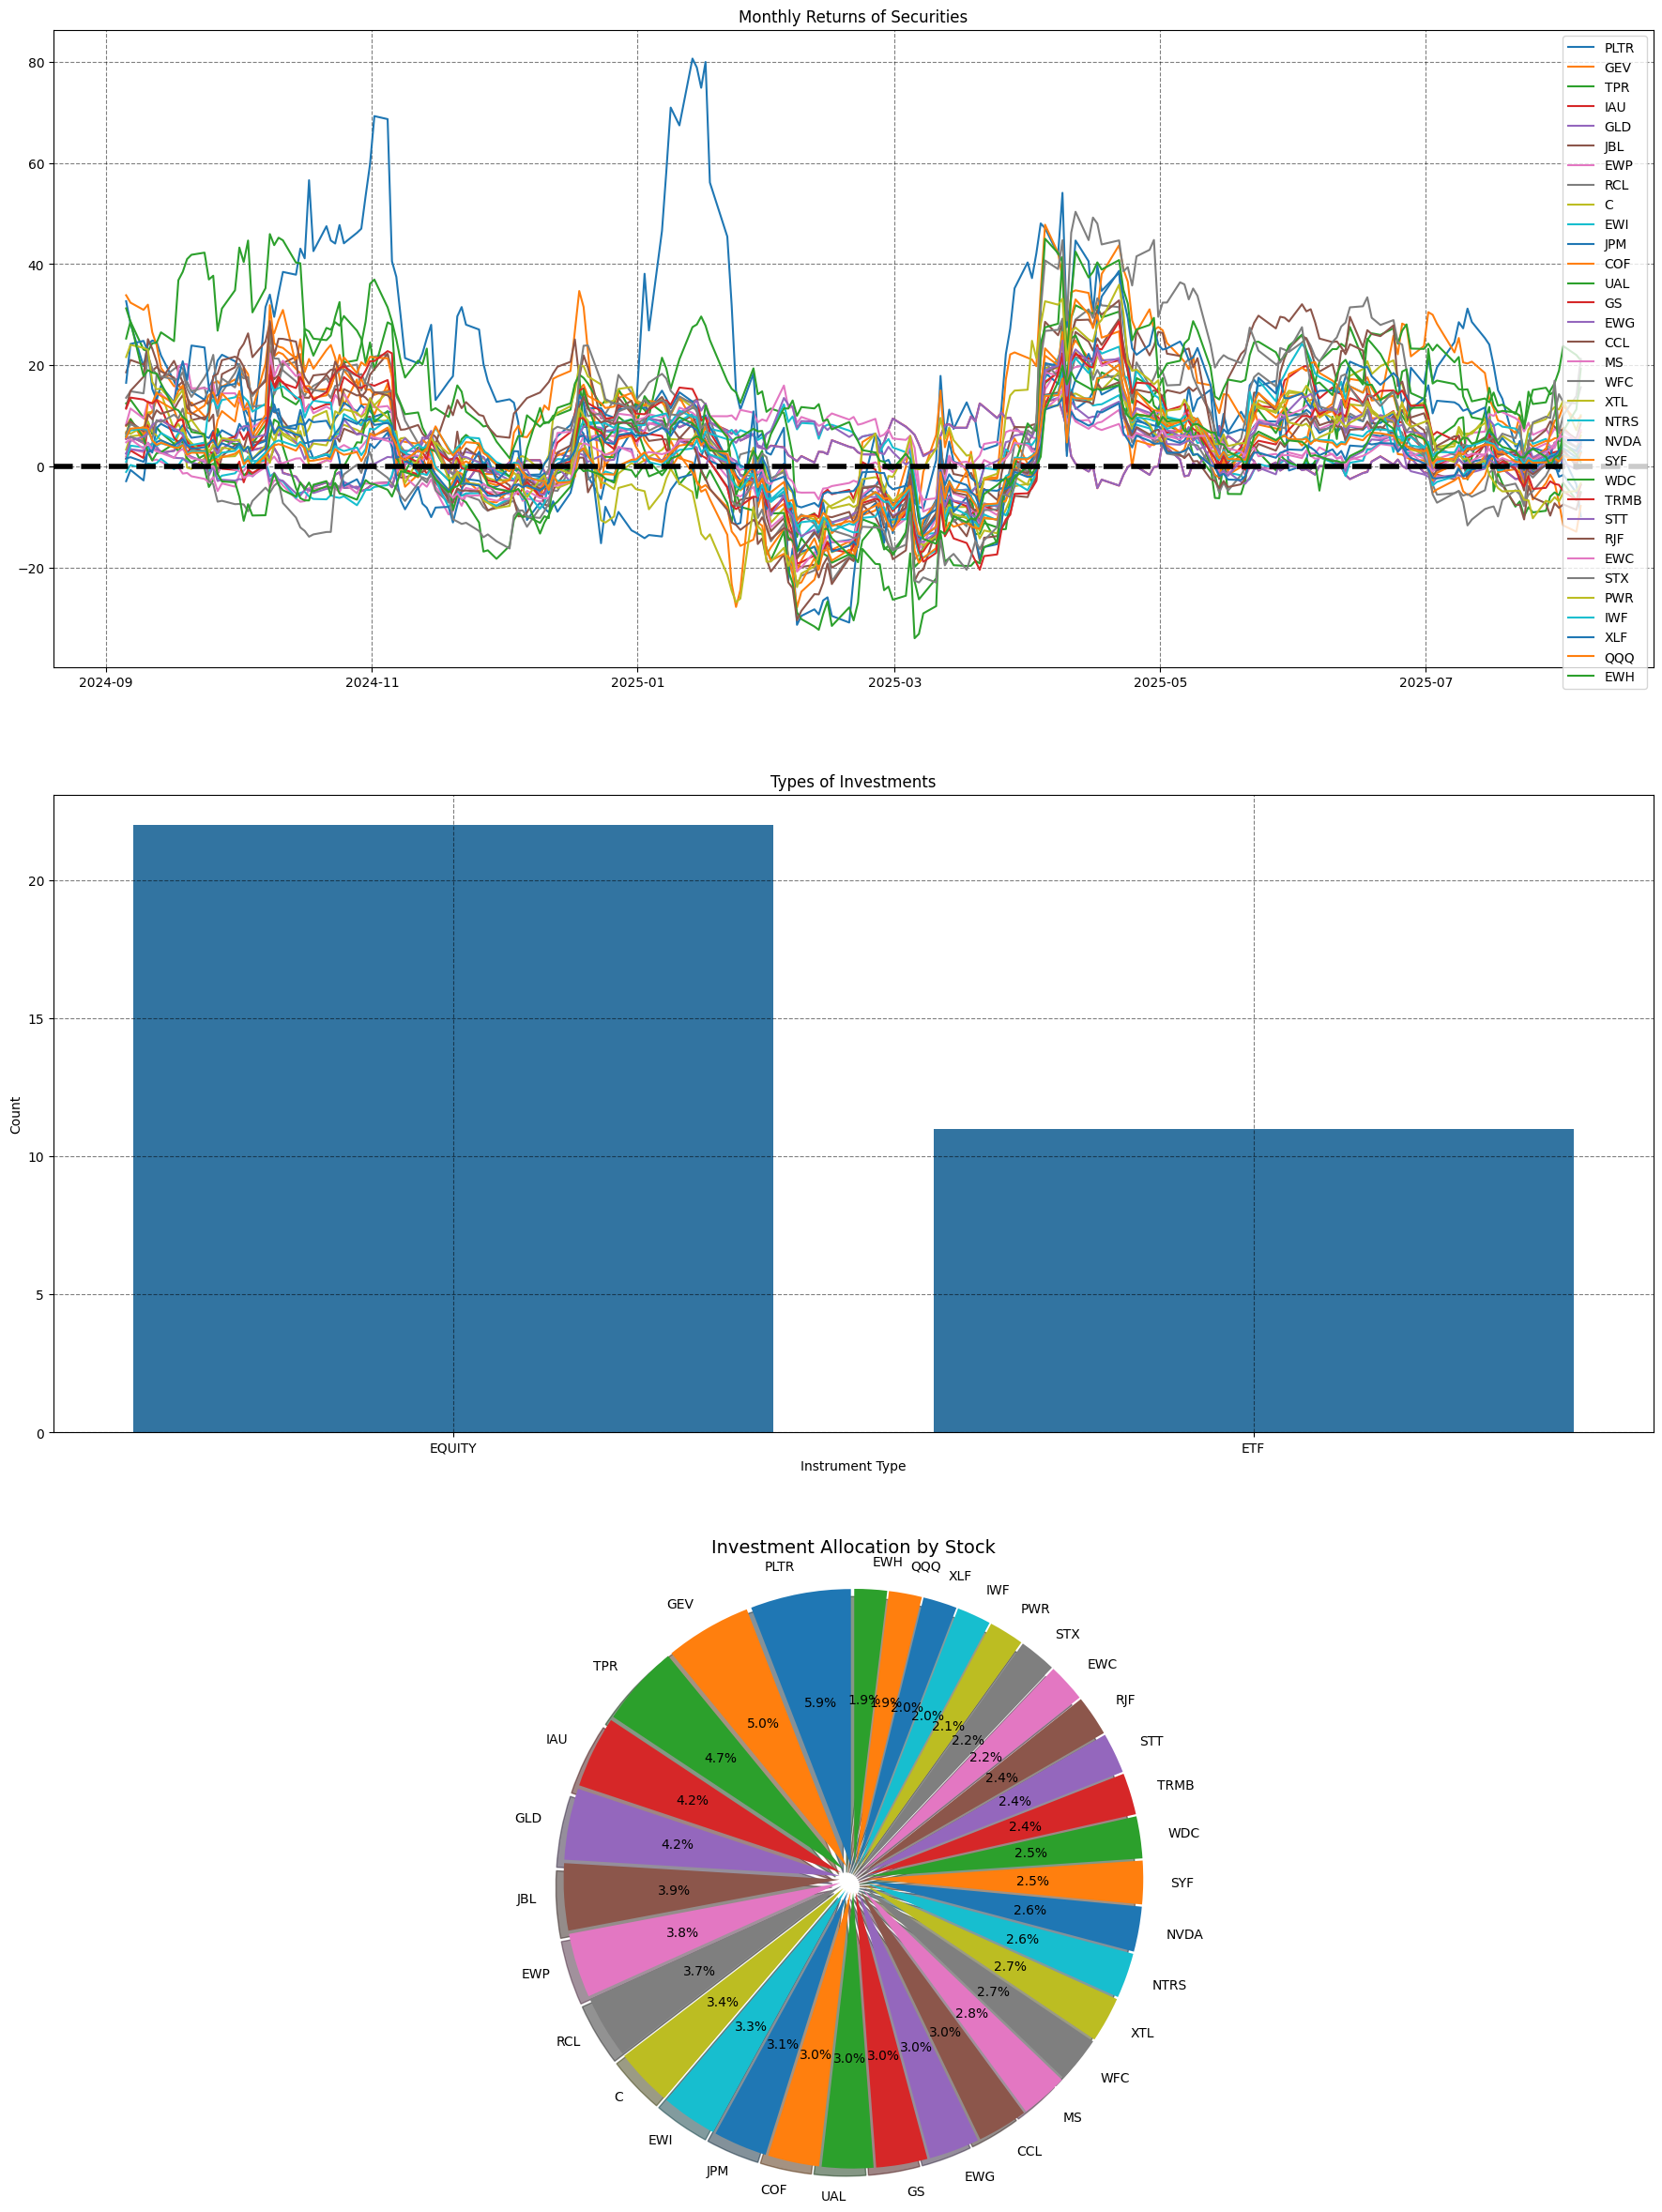

In [24]:
# Plot
fig, ax = plt.subplots(3, 1, figsize = (22, 30))

# Plot one
for sec in portfolio_df.Symbol:
    temp_df = all_security_data.query('Symbol == @sec')
    #temp_df.plot(x = temp.index, y = 'close', label = sec, ax=ax[0])
    ax[0].plot(temp_df.index, (temp_df['Monthly_Pct_Change'])*100, label = sec)
    
ax[0].legend()
ax[0].grid(linestyle = '--', alpha = 0.5, color = 'k')
ax[0].set_title("Monthly Returns of Securities")
ax[0].axhline(y = 0, color = 'k', linewidth = 4, linestyle = '--')

# Second Plot Etfs
sns.countplot(data=portfolio_df, x="instrumentType",ax=ax[1])
ax[1].set_xlabel("Instrument Type"); ax[1].set_ylabel("Count"); ax[1].set_title("Types of Investments")
ax[1].grid(linestyle = '--', alpha = 0.5, color = 'k')


# Third Plot
explode = [0.05] * len(portfolio_df)  # Slightly separate all slices

ax[2].pie(
    portfolio_df["invt_amount"],
    labels=portfolio_df["Symbol"],
    autopct='%1.1f%%',
    explode=explode,
    shadow=True,
    startangle=90,
    textprops={'fontsize': 10}
)

ax[2].set_title("Investment Allocation by Stock", fontsize=14)
ax[2].axis('equal')  # Make it a circle
plt.show()

# Thank you for viewing this notebook. In 1 month, I will create an update to see how our investments did

In [25]:
# Save df 
portfolio_df.to_csv("sept-04-portfolio.csv", index = False)